# Classification Example

In [47]:
# Libraries are imported
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler, LabelEncoder
import numpy as np
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, precision_recall_curve, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV

In [48]:
# Data is imported
df = pd.read_csv("/Users/baranalp.ozkan/Desktop/yazılım/Veri/btcmp_v6.csv", encoding="latin-1")

In [49]:
# First check of the data
df.head()

,YEAR,PERSONEL_COMMERCIAL,KARA_LISTE_KONTROL,KULLANIM_SEKLI,MARKA,TIP_GRUP,EGM_KULLANIM_SEKLI,MOTOR_GUCU,SILINDIR_HACMI,PLAKA_IL_KODU,...,IHALE_FILO_KODU,ARAC_ALT_CINS,ARAC_UST_CINS_ID,SEGMENT,AGIRLIK,ARAC_TIPI,YAKIT_TIPI,LPG_VAR_MI,MESLEK,HASAR_VAR_MI
0,2019,O,1,1,NaN,DFH5FD6H,4R561446512,109,1560,52,...,9999999,144RH5ER64HRE+,4.0,D,1578,10.0,D,H,45.0,0
1,2019,O,1,1,SD56G4SD5G4,1N1JTGH85FN1GF6H,4R561446512,90,1461,34,...,9999999,144RH5ER64HRE+,4.0,C,1280,10.0,D,H,3.0,0
2,2019,O,1,1,XC5B4XC5B4SFD,M1GH586M1G1MH51HG,4R561446512,140,1395,34,...,9999999,5H4DF56H4DF,4.0,C,1268,10.0,O,H,2.0,0
3,2019,O,1,1,4GH53445,M1GH5M1GH35M,4R561446512,75,1499,9,...,9999999,DF4H,4.0,B,1108,10.0,D,H,45.0,0
4,2019,T,1,1,NaN,M1GH5M1GH23,4R561446512,112,1560,34,...,9999999,DF4H,4.0,C,1350,10.0,D,H,NaN,0


## Data Preprocessing

In [4]:
mean_of_agırlık = df[df["AGIRLIK"] < 999999]["AGIRLIK"].mean()
df["AGIRLIK"] = df["AGIRLIK"].replace(999999, mean_of_agırlık)

In [5]:
std_scaler = StandardScaler()
df["ARAC_BEDELI"] = std_scaler.fit_transform(df[["ARAC_BEDELI"]])
df["AGIRLIK"] = std_scaler.fit_transform(df[["AGIRLIK"]])

In [6]:
df["ARAC_TIPI"].fillna(df["ARAC_TIPI"].mode(), inplace=True)

In [7]:
fill_others = [
    "MARKA",
    "EGM_KULLANIM_SEKLI",
    "YAKIT_TIPI",
    "EGM_CINSI",
    "ARAC_ALT_CINS",
    "SEGMENT",
    "MEDENI_DURUM",
]

for col in fill_others:
    df[col].fillna("OTHER", inplace=True)

In [8]:
df["PERT_SORGU"] = (
    df["PERT_SORGU"].fillna("OTHER").replace("0", "OTHER").replace("8", "OTHER")
)

In [9]:
dfa = pd.DataFrame()

dfa["ONCEKI_POLICE_BASLANGIC_TARIHI"] = (
    df["ONCEKI_POLICE_BASLANGIC_TARIHI"]
    .fillna("5/12/2018 0:00")
    .apply(lambda x: pd.to_datetime(x))
)
dfa["ONCEKI_POLICE_BITIS_TARIHI"] = (
    df["ONCEKI_POLICE_BITIS_TARIHI"]
    .replace("999", "5/12/2018 0:00")
    .apply(lambda x: pd.to_datetime(x))
)
dfa["ONCEKI_POLICE_BASLANGIC_TARIHI"] = pd.to_datetime(
    dfa["ONCEKI_POLICE_BASLANGIC_TARIHI"], utc=True
)
dfa["ONCEKI_POLICE_BITIS_TARIHI"] = pd.to_datetime(
    dfa["ONCEKI_POLICE_BITIS_TARIHI"], utc=True
)
dfa["ONCEKI_POLICE_BASLANGIC_TARIHI"] = pd.DatetimeIndex(
    dfa["ONCEKI_POLICE_BASLANGIC_TARIHI"]
).year
dfa["ONCEKI_POLICE_BITIS_TARIHI"] = pd.DatetimeIndex(
    dfa["ONCEKI_POLICE_BITIS_TARIHI"]
).year

dfa["YEAR_DIFF"] = (
    dfa["ONCEKI_POLICE_BITIS_TARIHI"] - dfa["ONCEKI_POLICE_BASLANGIC_TARIHI"]
)
df["YEAR_DIFF"] = dfa["YEAR_DIFF"]

In [10]:
cols = [
    "PERSONEL_COMMERCIAL",
    "LPG_VAR_MI",
    "TCK_PLAKA_SORGU",
    "ORJINAL_OLMAYAN_PARCA_VARMI",
    "ONCEKI_KASKO_POLICESI_VAR_MI",
]
for col in cols:
    exec(
        f"le_{col} = LabelEncoder()"
    )  # create label encoder with name "le_X", where X is column name
    exec(f"df.{col} = le_{col}.fit_transform(df.{col})")

In [11]:
df = df.drop(
    columns=[
        "KARA_LISTE_KONTROL",
        "KULLANIM_SEKLI",
        "IHALE_FILO_KODU",
        "UYGULANAN_BASAMAK_KODU",
        "ARAC_TARIFE_GRUP_KODU",
        "IHALE_FILO_KODU",
    ]
)

In [12]:
ohe_cols = [
    "EGM_KULLANIM_SEKLI",
    "EGM_CINSI",
    "YAKIT_TIPI",
    "ARAC_ALT_CINS",
    "SEGMENT",
    "PERT_SORGU",
    "MEDENI_DURUM",
    "ALT_KULLANIM_SEKLI",
    "CLAIM_EXPERIENCE",
    "ARAC_TIPI",
]
df_new = df.copy()
for column in ohe_cols:
    tempdf = pd.get_dummies(df_new[column], prefix=column)
    df_new = pd.merge(
        left=df_new,
        right=tempdf,
        left_index=True,
        right_index=True,
    )
    df_new = df_new.drop(columns=column)

In [13]:
df_new.drop(
    columns=[
        "SILINDIR_HACMI",
        "PLAKA_IL_KODU",
        "ONCEKI_ÅIRKET",
        "ONCEKI_POLICE_BASAMAK_KODU",
        "ONCEKI_POLICE_BASLANGIC_TARIHI",
        "ONCEKI_POLICE_BITIS_TARIHI",
        "PAKET_TIPI",
        "EGM_CINSI.1",
        "IKAMET_IL_KODU",
        "ARAC_UST_CINS_ID",
        "MESLEK",
    ],
    inplace=True,
)

In [14]:
le_cols = ["MARKA", "TIP_GRUP"]
le = LabelEncoder()
for col in le_cols:
    df_new[col] = le.fit_transform(df_new[col])


In [15]:
df_new.head()

,YEAR,PERSONEL_COMMERCIAL,MARKA,TIP_GRUP,MOTOR_GUCU,ARAC_BEDELI,HASARSIZLIK_INDIRIMI,ARAC_YASI,ONCEKI_KASKO_POLICESI_VAR_MI,ORJINAL_OLMAYAN_PARCA_VARMI,...,ALT_KULLANIM_SEKLI_100,ALT_KULLANIM_SEKLI_102,ALT_KULLANIM_SEKLI_103,CLAIM_EXPERIENCE_0,CLAIM_EXPERIENCE_K,CLAIM_EXPERIENCE_T,CLAIM_EXPERIENCE_X,ARAC_TIPI_10.0,ARAC_TIPI_20.0,ARAC_TIPI_40.0
0,2019,0,23,139,109,-0.627633,5,9,0,1,...,1,0,0,1,0,0,0,1,0,0
1,2019,0,31,21,90,-0.785504,3,8,0,1,...,1,0,0,1,0,0,0,1,0,0
2,2019,0,38,215,140,0.307868,0,6,1,1,...,1,0,0,0,0,1,0,1,0,0
3,2019,0,2,217,75,-0.507025,0,6,1,0,...,1,0,0,0,0,1,0,1,0,0
4,2019,1,23,216,112,-0.572547,0,7,0,1,...,1,0,0,1,0,0,0,1,0,0


## Modelling

In [16]:
from sklearn.model_selection import train_test_split

X = df_new.drop(columns=["HASAR_VAR_MI"])
y = df_new["HASAR_VAR_MI"]

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [17]:
from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [18]:
pred = model.predict(x_test)

In [19]:
from sklearn.metrics import accuracy_score, f1_score

print(f"Accuracy: {accuracy_score(y_test, pred)}")
print(f"F1 Score: {f1_score(y_test, pred)}")

Accuracy: 0.8150943396226416
F1 Score: 0.11664899257688228


              precision    recall  f1-score   support

           0       0.86      0.57      0.68      3663
           1       0.24      0.61      0.35       842

    accuracy                           0.57      4505
   macro avg       0.55      0.59      0.52      4505
weighted avg       0.75      0.57      0.62      4505



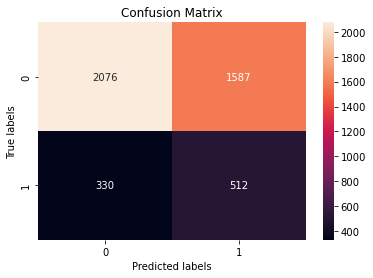

In [28]:
treshold = 15

pred_prob = model.predict_proba(x_test)[:, 1]
pred_prob_bool = pred_prob >= (treshold / 100)

cm = confusion_matrix(y_test, pred_prob_bool)
ax = plt.subplot()

sns.heatmap(cm, annot=True, fmt="", ax=ax)
# annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel("Predicted labels")
ax.set_ylabel("True labels")
ax.set_title("Confusion Matrix")

print(classification_report(y_test, pred_prob_bool))

In [29]:
pred_prob

array([0.07439694, 0.32329047, 0.1337885 , ..., 0.09865133, 0.19023728,
       0.13485412], dtype=float32)

In [30]:
df_y = pd.DataFrame({"prob": pred_prob, "HASAR_VAR_MI": y_test})

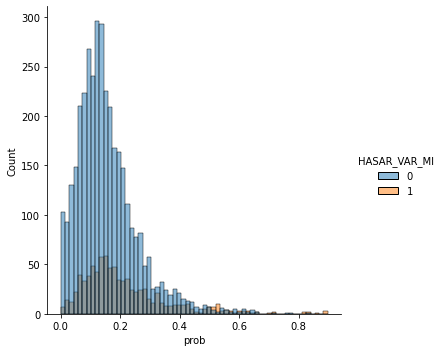

In [31]:
sns.displot(df_y, x="prob", hue="HASAR_VAR_MI")

In [32]:
df_y.prob.max()

0.8978456854820251

In [33]:
from sklearn.ensemble import RandomForestClassifier

model2 = RandomForestClassifier()
model2.fit(x_train, y_train)
pred2 = model2.predict(x_test)
from sklearn.metrics import accuracy_score, f1_score

print(f"Accuracy: {accuracy_score(y_test, pred2)}")
print(f"F1 Score: {f1_score(y_test, pred2)}")

Accuracy: 0.8250832408435073
F1 Score: 0.3706070287539936


              precision    recall  f1-score   support

           0       0.87      0.60      0.71      3663
           1       0.26      0.61      0.36       842

    accuracy                           0.60      4505
   macro avg       0.56      0.61      0.54      4505
weighted avg       0.76      0.60      0.65      4505



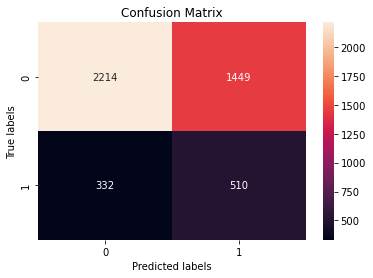

In [34]:
treshold = 15

pred_prob2 = model2.predict_proba(x_test)[:, 1]
pred_prob_bool2 = pred_prob2 >= (treshold / 100)

cm = confusion_matrix(y_test, pred_prob_bool2)
ax = plt.subplot()

sns.heatmap(cm, annot=True, fmt="", ax=ax)
# annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel("Predicted labels")
ax.set_ylabel("True labels")
ax.set_title("Confusion Matrix")

print(classification_report(y_test, pred_prob_bool2))

In [35]:
df_y2 = pd.DataFrame({"prob": pred_prob2, "HASAR_VAR_MI": y_test})

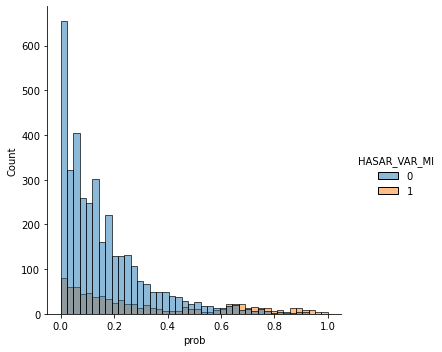

In [36]:
sns.displot(df_y2, x="prob", hue="HASAR_VAR_MI")


In [37]:
df_y2.prob.max()

1.0